<a href="https://colab.research.google.com/github/devansong/network_workshop/blob/master/R_Wildlife_Trade_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#R Code for URI Illegal Wildlife Trafficking: R workshop in network analysis

## Test
Before we begin the class, let's make sure we can run some simple code and plot a graph. 
Click on each cell of code and press "shift + enter"

In [0]:
x <- c(1,3,6,9,12)
y <- c(1.5,2,7,8,15)
plot(x,y, xlab="x axis", ylab="y axis", main="my plot", ylim=c(0,20), xlim=c(0,15), pch=19, col="blue", cex=3)

If you see a simple scatter plot with 5 data points, you have successfully run the code! Now, run the next section of code (8 cells), then we can return to introductions while we wait for the packages to load and the data to download

##install packages, load libraries and data

In [15]:
install.packages("igraph")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("igraph"):
“installation of package ‘igraph’ had non-zero exit status”


Load 3 libraries that we will be using



In [14]:
library(tidyverse)
library(igraph)
library(ggplot2)

ERROR: ignored

Now, we will load the CITES wildlife trade data


In [3]:
devtools::install_github("ropensci/citesdb")


Skipping install of 'citesdb' from a github remote, the SHA1 (4da9daa1) has not changed since last install.
  Use `force = TRUE` to force installation



In [0]:
library(citesdb)

In [0]:
cites_db_download()

In [7]:
cites_shipments()

# Source:   table<cites_shipments> [?? x 19]
# Database: MonetDBEmbeddedConnection
    Year Appendix Taxon Class Order Family Genus Term  Quantity Unit  Importer
   <int> <chr>    <chr> <chr> <chr> <chr>  <chr> <chr>    <dbl> <chr> <chr>   
 1  1975 II       Ailu… Mamm… Carn… Ailur… Ailu… live         2 NA    CH      
 2  1975 II       Alda… Rept… Test… Testu… Alda… bodi…        1 NA    CH      
 3  1975 I        Alli… Rept… Croc… Allig… Alli… skins       16 NA    CH      
 4  1975 I        Anod… Aves  Psit… Psitt… Anod… live         2 NA    CH      
 5  1975 III      Bala… Mamm… Ceta… Balae… NA    bone…       25 NA    BE      
 6  1975 III      Bala… Mamm… Ceta… Balae… NA    bone…        7 NA    CA      
 7  1975 III      Bala… Mamm… Ceta… Balae… NA    bone…        7 NA    DE      
 8  1975 II       Boa … Rept… Serp… Boidae Boa   live        22 NA    CH      
 9  1975 II       Boa … Rept… Serp… Boidae Boa   live         7 NA    XX      
10  1975 II       Bran… Aves  Anse… Anati… Bran…

In [0]:
master <- cites_shipments() %>% 
#drop_na(Importer) %>%
#drop_na(Exporter) %>%
collect()


In [0]:
master$Importer[is.na(master$Importer)] <- ""
master$Exporter[is.na(master$Exporter)] <- ""

##Explore dataset


In [10]:
str(master)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	20215030 obs. of  19 variables:
 $ Year                  : int  1975 1975 1975 1975 1975 1975 1975 1975 1975 1975 ...
 $ Appendix              : chr  "II" "II" "I" "I" ...
 $ Taxon                 : chr  "Ailurus fulgens" "Aldabrachelys gigantea" "Alligator mississippiensis" "Anodorhynchus leari" ...
 $ Class                 : chr  "Mammalia" "Reptilia" "Reptilia" "Aves" ...
 $ Order                 : chr  "Carnivora" "Testudines" "Crocodylia" "Psittaciformes" ...
 $ Family                : chr  "Ailuridae" "Testudinidae" "Alligatoridae" "Psittacidae" ...
 $ Genus                 : chr  "Ailurus" "Aldabrachelys" "Alligator" "Anodorhynchus" ...
 $ Term                  : chr  "live" "bodies" "skins" "live" ...
 $ Quantity              : num  2 1 16 2 25 7 7 22 7 2 ...
 $ Unit                  : chr  NA NA NA NA ...
 $ Importer              : chr  "CH" "CH" "CH" "CH" ...
 $ Exporter              : chr  "DE" "SC" "DE" "PT" ...
 $ Origin           

In [11]:
head(master)

Year,Appendix,Taxon,Class,Order,Family,Genus,Term,Quantity,Unit,Importer,Exporter,Origin,Purpose,Source,Reporter.type,Import.permit.RandomID,Export.permit.RandomID,Origin.permit.RandomID
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1975,II,Ailurus fulgens,Mammalia,Carnivora,Ailuridae,Ailurus,live,2,NA,CH,DE,NA,Z,NA,I,NA,NA,NA
1975,II,Aldabrachelys gigantea,Reptilia,Testudines,Testudinidae,Aldabrachelys,bodies,1,NA,CH,SC,NA,NA,NA,I,NA,NA,NA
1975,I,Alligator mississippiensis,Reptilia,Crocodylia,Alligatoridae,Alligator,skins,16,NA,CH,DE,NA,NA,NA,I,NA,NA,NA
1975,I,Anodorhynchus leari,Aves,Psittaciformes,Psittacidae,Anodorhynchus,live,2,NA,CH,PT,NA,Z,NA,I,NA,NA,NA
1975,III,Balaenidae spp.,Mammalia,Cetacea,Balaenidae,NA,bone carvings,25,NA,BE,CA,NA,NA,NA,E,NA,NA,NA
1975,III,Balaenidae spp.,Mammalia,Cetacea,Balaenidae,NA,bone carvings,7,NA,CA,DE,CA,NA,NA,I,NA,NA,NA


In [12]:
min(master$Year) 

[1] 1975

In [13]:
max(master$Year) 

[1] 2018

In [14]:
table(master$Class) 


   Actinopteri       Amphibia       Anthozoa      Arachnida           Aves 
        314305          32595        3290126          11576         992282 
      Bivalvia    Cephalopoda    Coelacanthi      Dipneusti Elasmobranchii 
         94267             61             58            464           2225 
    Gastropoda   Hirudinoidea  Holothuroidea       Hydrozoa        Insecta 
         42226           8345            893          20579          52371 
      Mammalia       Reptilia 
       2243332        8161927 

In [15]:
sort(table(master$Class))


   Coelacanthi    Cephalopoda      Dipneusti  Holothuroidea Elasmobranchii 
            58             61            464            893           2225 
  Hirudinoidea      Arachnida       Hydrozoa       Amphibia     Gastropoda 
          8345          11576          20579          32595          42226 
       Insecta       Bivalvia    Actinopteri           Aves       Mammalia 
         52371          94267         314305         992282        2243332 
      Anthozoa       Reptilia 
       3290126        8161927 

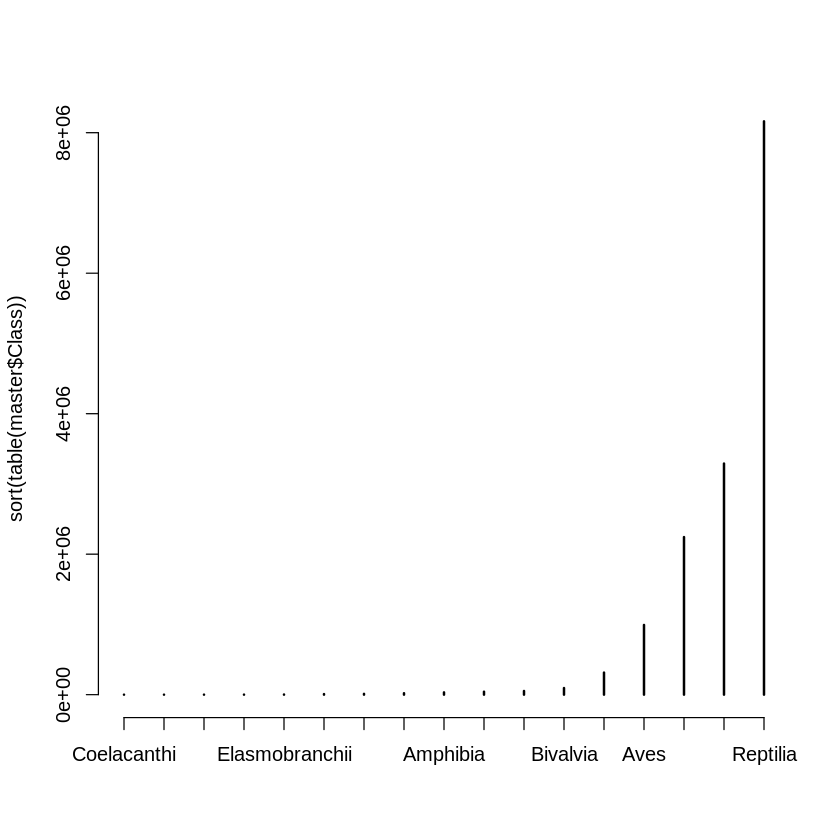

In [16]:
plot(sort(table(master$Class)))

##Functions

In [0]:
create_network <- function(data){
  
  sources <- data %>%
    distinct(Exporter) %>%
    rename(label = Exporter) #creates data frame of all countries of origin 
  
  destinations <- data %>%
    distinct(Importer) %>%
    rename(label = Importer)#creates data frame of all countries importing 
  
  nodes <- full_join(sources, destinations, by = "label") #creates data frame of all unique countries in your dataset 
  nodes <- nodes %>% rowid_to_column("id") #creates numerical id for each unique country 

# this next section of code creates a tibble with export id, import id, and weight by number of shipments ~~~~  
  per_route <- data %>%  
    group_by(Exporter, Importer) %>%
    summarise(weight = n()) %>% #number of observations in the current group
    ungroup() #removes grouping 
  edges <- per_route %>% 
    left_join(nodes, by = c("Exporter" = "label")) %>% 
    rename(from = id)
  edges <- edges %>% 
    left_join(nodes, by = c("Importer" = "label")) %>% 
    rename(to = id)
  edges <- select(edges, from, to, weight)
#~~~~~~~~~#
  
  #creates a directed igraph network from the edges and nodes defined above   
  net <- graph_from_data_frame(d=edges, vertices=nodes, directed=T) 
}

In [0]:
plot_network <- function(igraph_network, title="trade network", weight_denom=100, layout=layout_with_mds){
  E(igraph_network)$width <- E(igraph_network)$weight/weight_denom
  l <- layout(igraph_network)
  plot(
    igraph_network,
    edge.color= rgb(70/255, 130/255, 180/255, 0.6),
    edge.arrow.size=.001, 
    vertex.size = 7, 
    vertex.color="gold", #(65,105,225)
    vertex.label = V(igraph_network)$id,
    vertex.label.cex = 0.6, 
    vertex.label.color = "black", 
    rescale=T, 
    layout=l*3.0, 
    main=title) 
}

##Create and visualize network

In [12]:
master_network <-create_network(master) 


ERROR: ignored

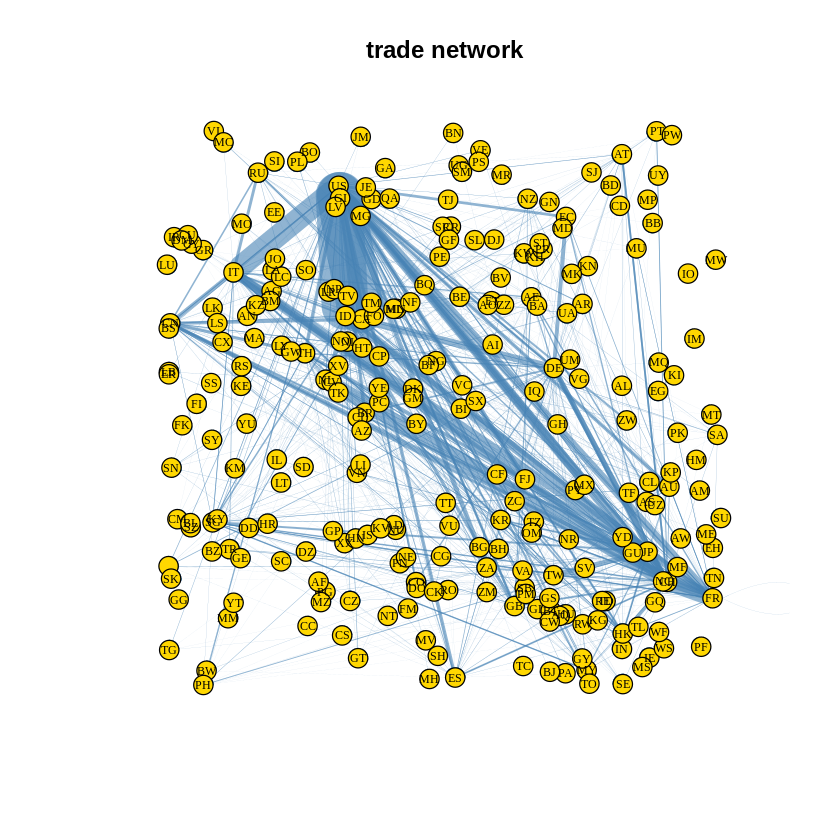

In [0]:
plot_network(master_network, weight_denom=40000, layout = layout_randomly)


In [0]:
list.vertex.attributes(master_network)
which(V(master_network)$label == "CZ")
which(V(master_network)$label == "US")
which(V(master_network)$label == "")
# Remove CZ (seems problematic) and empty vertex 
master_CZ_rem <- delete_vertices(master_network, c(220))
master_CZ_rem <- delete_vertices(master_network, c(43))

[1] "name"  "label"

[1] 219

[1] 8

[1] 32

In [0]:
master_network <- master_CZ_rem
s1 <- subgraph.edges(master_network, E(master_network)[E(master_network)$weight>2000], del=F)
s2 <- delete_vertices(s1, degree(s1, mode = "in")==0)
plot_network(s2, weight_denom=40000, layout = layout_randomly)

In [0]:
plot_network(s2, weight_denom=40000, layout = layout_with_fr)


In [0]:
plot_network(s2, weight_denom=40000, layout = layout_with_mds)


##Create 2 subsets of the data, create networks, and visually compare them

In [0]:
Amp_1992 <- subset(master, Class == "Amphibia" & Year == "1992") #Creates subset of 1992 amphibians
Amp_2012 <- subset(master, Class == "Amphibia" & Year == "2012") #Creates subset of 2012 amphibians


In [0]:
net1<-create_network(Amp_1992) #Create network for subset 1
net2 <-create_network(Amp_2012) #Create network for subset 2

In [0]:
par(mfrow=c(1,2))
plot_network(net1, title="1992", weight_denom=5, layout= layout_on_sphere)
plot_network(net2, title="2012", weight_denom=5, layout= layout_on_sphere)


##Cluster analysis

In [0]:
par(mfrow=c(1,2))
cfg <- cluster_fast_greedy(as.undirected(net1))
plot(cfg, as.undirected(net1)) 
title(main = "Amphibians 1992")
cfg <- cluster_fast_greedy(as.undirected(net2))
plot(cfg, as.undirected(net2)) 
title(main = "Amphibians 2012")

##Exercise


In [0]:
Modify the above 4 sections of code to compare two

##Network and node descriptive stats

In [1]:
ecount(net1)/(vcount(net1)*(vcount(net1)-1)) #for a directed network
ecount(net2)/(vcount(net2)*(vcount(net2)-1)) #for a directed network

ERROR: ignored

In [4]:
reciprocity(net1)
reciprocity(net2)

ERROR: ignored

In [0]:
transitivity(net1, type="global")
transitivity(net2, type="global")

In [0]:
diameter(net1, directed=F, weights=NA)
diameter(net2, directed=F, weights=NA)



In [0]:
deg1 <- degree(net1, mode="all") #NODE METRICS ************
plot(net1, vertex.size=deg*3, edge.arrow.size=0.1)
hist(deg1, breaks=1:vcount(net1)-1, main="Histogram of node degree")
deg2 <- degree(net1, mode="all") #NODE METRICS ************
plot(net2, vertex.size=deg*3, edge.arrow.size=0.1)
hist(deg2, breaks=1:vcount(net1)-1, main="Histogram of node degree")
